In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import io


Start of Problem 2

2. Epidemic spreading on the configuration model allows us to test simple targeted vaccination strategies since not all individuals (nodes) are considered equal. Let us consider
a simple example on an endemic Influenza epidemic, and test the impact of vaccination
strategies knowing that around 40% of adults tend to get vaccinated.
a) Write a heterogeneous mean-field system for an SIS epidemic model on a configuration model network. You should obtain a system of equations for ˙I1, . . . ,
˙Ikmax
,
where kmax is the largest degree in the network. Feel free to nondimensionalize
your system if you wish.
b) Modify the above system of equations by adding new compartments for vaccinated nodes. Assume that around vaccinated nodes, the transmission rate (both
to and from these nodes) is reduced by a multiplicative factor (1-ρ). For example, each vaccinated and susceptible individual with degree k should move from
compartment S
V
k
to I
V
k with rate (1 − ρ)βkθ (where θ is defined in Eq. (10) of
“Mean-field Models on Networks” handout, but needs to be modified).
1
c) Using the integrator of your choice, test how strong ρ needs to be to eradicate an
outbreak with the following parameters: transmission rate β = 0.3 (week−1
) and
recovery rate α = 1 (week−1
) in a population with a geometric degree distribution
pk = p(1 − p)
k with p = 1/4. Assume that a random 40% of the population gets
vaccinated.
d) Repeat c) but now assume that the vaccination campaign convinced the 40% of
nodes with highest degree to get vaccinated.

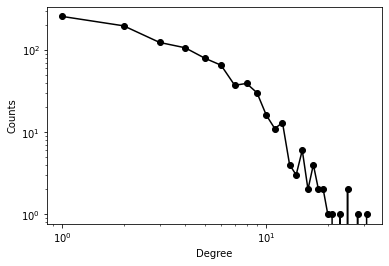

4.034 4034


In [2]:
degrees = np.random.geometric(0.25, 1000)
cm = nx.configuration_model(degrees)
degree_freq = nx.degree_histogram(cm)

degrees = list(range(len(degree_freq)))
plt.loglog(degrees[1:], degree_freq[1:],'ko-') 
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.show()

# Parameters of the model
beta = 0.0025 #transmission rate

I0 = 0.001 #initial fraction of infected nodes
S0 = 1.0 - I0

# Initial conditions
cm_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = sum(cm_deg_sum)
avg_k = sum(cm_deg_sum) / cm.number_of_nodes()
print(avg_k, total_degree)
Sk = np.zeros((len(degree_freq))) #array for expected S_k
Ik = np.zeros((len(degree_freq))) #array for expected I_k

for k in range(len(degree_freq)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Sk[k] = degree_freq[k]*S0
  Ik[k] = degree_freq[k]*I0

In [3]:
# Run the model

# Discrete steps of Euler's methods
res = [] #list of results
history = []
S = S0; I = I0; #set initial conditions
h = 0.1; #timestep
T = np.arange(1,1000/h)
for t in T:
  
  # Calculate the mean-field
  theta = 0.0
  for k in range(len(degree_freq)):
    theta += k*Ik[k]/total_degree
  history.append(theta)

  # Set initial global quantities
  S = 0.0
  I = 0.0

  # Run Euler's method for all degree classes k
  for k in range(len(degree_freq)):
    # calculate speeds
    delta_Sk = -beta*k*theta*Sk[k] 
    delta_Ik = beta*k*theta*Sk[k] 

    # update dynamical variables
    Sk[k] += delta_Sk*h #Ik(t+h)
    Ik[k] += delta_Ik*h #Ik(t+h)

    # update global quantities
    S += Sk[k]
    I += Ik[k]
  res.append((S/cm.number_of_nodes(),I/cm.number_of_nodes()))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays
St,It = map(np.array, zip(*res))

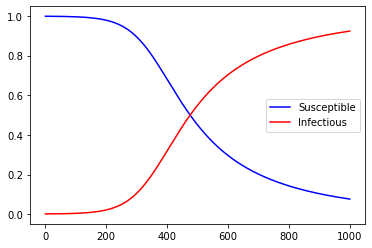

In [4]:
#plot results
fig,ax = plt.subplots()
ax.plot(h*T, St, 'b', label='Susceptible')
ax.plot(h*T,It, 'r', label='Infectious')
ax.legend();

In [5]:
Ik

array([  0.        , 180.28683599, 177.03578607, 133.57582444,
       106.50189513,  83.89790432,  59.98096514,  50.995778  ,
        31.99930892,  19.99988735,  18.9999721 ,  15.99999388,
        14.9999985 ,   8.99999977,   5.99999996,   4.99999999,
         1.        ,   2.        ,   1.        ,   0.        ,
         0.        ,   1.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         1.        ])

In [5]:
def get_geom_seq(n,p):
    degrees = np.random.geometric(p, n)
    while sum(degrees)%2 !=0:
        degrees = np.random.geometric(p, n)

    return degrees



degrees = get_geom_seq(4000,.25)


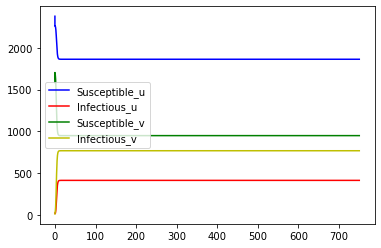

In [6]:
def calc_theta(degree_freq, Ik_u, Ik_v, rho, total_degree):
    theta = 0
    for k in range(len(degree_freq)):
            theta += (k*Ik_u[k] + k*Ik_v[k]*(1-rho))/total_degree

    return theta

def sis_vaccine_model_mod(degree_sequence):
    # Graph Setup
    G = nx.configuration_model(degree_sequence)
    degree_freq = nx.degree_histogram(G)
    G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
    total_degree = sum(G_deg_sum)

    I0 = 0.01 #initial fraction of infected vaccinated nodes
    S0 = 1 - I0 # initial fraction of susceptible, unvaccinated nodes

    U0 = 0.6
    V0 = 0.4

    Sk_v = np.zeros(len(degree_freq)) #array for expected S_k^V
    Ik_v = np.zeros(len(degree_freq)) #array for expected I_k^V
    Sk_u = np.zeros(len(degree_freq)) #array for expected S_k^U
    Ik_u = np.zeros(len(degree_freq)) #array for expected I_k^U

    perc_array = np.cumsum(degree_freq)/len(degree_sequence)
    idx = (np.abs(perc_array - U0)).argmin()

    for k in range(idx+1):
        #set an expectation of I0 fraction of nodes of degree k infectious
        Ik_u[k] = degree_freq[k]*I0
        Sk_u[k] = degree_freq[k]*S0

    for k in range(idx+1, len(degree_freq)):
        Ik_v[k] = degree_freq[k]*I0
        Sk_v[k] = degree_freq[k]*S0

    # SIS Set up
    beta = 0.3
    h = 0.01
    alpha = 1
    rho = 0.0 # vaccination reduction on transmission fed into (1-rho)
    history = []

    num_steps = 750
    T = np.arange(num_steps/h)
    S_u = np.zeros(len(T))
    I_u = np.zeros(len(T))
    S_v = np.zeros(len(T))
    I_v = np.zeros(len(T))

    S = np.zeros(len(T))
    I = np.zeros(len(T))

    S_u[0] = S0*U0*len(degree_sequence)
    I_u[0] = I0*U0*len(degree_sequence)
    S_v[0] = S0*V0*len(degree_sequence)
    I_v[0] = I0*V0*len(degree_sequence)

    S[0] = S_u[0] + S_v[0]
    I[0] = I_u[0] + I_v[0]


    # Run model
    for i in range(0, len(T)-1):
        # Calculate theta
        theta = calc_theta(degree_freq, Ik_u, Ik_v, rho, total_degree)

        history.append(theta)
        sus = 0
        inf = 0

        sus_u = 0
        inf_u = 0
        sus_v = 0
        inf_v = 0

        for k in range(len(degree_freq)):
            delta_Sk_v = alpha*Ik_v[k] - beta*k*theta*Sk_v[k]
            delta_Ik_v = beta*k*theta*Sk_v[k] - alpha*Ik_v[k]

            delta_Sk_u = alpha*Ik_u[k] - beta*k*theta*Sk_u[k]
            delta_Ik_u = beta*k*theta*Sk_u[k] - alpha*Ik_u[k]

            Sk_v[k] += delta_Sk_v*h
            Ik_v[k] += delta_Ik_v*h
            Sk_u[k] += delta_Sk_u*h
            Ik_u[k] += delta_Ik_u*h

            # update global quantities
            sus += Sk_v[k] + Sk_u[k]
            inf += Ik_v[k] + Ik_u[k]

            sus_v += Sk_v[k]
            sus_u += Sk_u[k]
            inf_v += Ik_v[k]
            inf_u += Ik_u[k]


        S[i+1] = sus
        I[i+1] = inf

        S_u[i+1] = sus_u
        I_u[i+1] = inf_u
        S_v[i+1] = sus_v
        I_v[i+1] = inf_v

    fig,ax = plt.subplots()
    ax.plot(h*T, S_u, 'b', label='Susceptible_u')
    ax.plot(h*T,I_u, 'r', label='Infectious_u')
    ax.plot(h*T,S_v, 'g', label='Susceptible_v')
    ax.plot(h*T,I_v, 'y', label='Infectious_v')
    ax.legend();
sis_vaccine_model_mod(degrees)

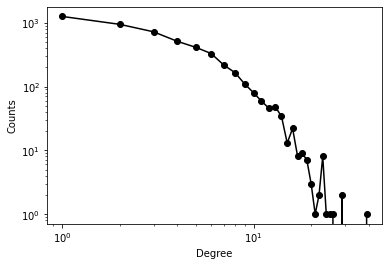

3.9468 19734


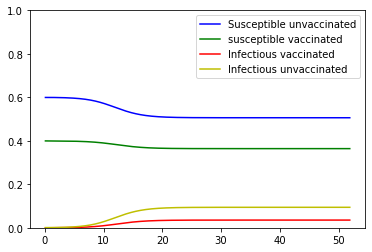

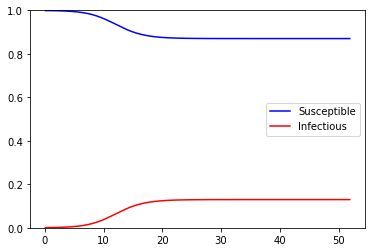

In [71]:
# random 40% vaccinated
degrees = get_geom_seq(5000,.25)
cm = nx.configuration_model(degrees)
degree_freq = nx.degree_histogram(cm)

degrees = list(range(len(degree_freq)))
plt.loglog(degrees[1:], degree_freq[1:],'ko-') 
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.show()

# Parameters of the model
beta = 0.3 #transmission rate
p = .5
alpha = 1

Iu0 = 0.001
Iv0 = 0
Su_0 = 0.6*(1-Iu0-Iv0)
Sv_0 = 0.4*(1-Iu0-Iv0)

# Initial conditions
cm_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = sum(cm_deg_sum)
avg_k = sum(cm_deg_sum) / cm.number_of_nodes()
print(avg_k, total_degree)
Suk = np.zeros((len(degree_freq))) #array for expected S_k
Svk = np.zeros((len(degree_freq))) #array for expected S_k
Iuk = np.zeros((len(degree_freq))) #array for expected I_k
Ivk = np.zeros((len(degree_freq))) #array for expected I_k

for k in range(len(degree_freq)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Suk[k] = degree_freq[k]*Su_0
  Svk[k] = degree_freq[k]*Sv_0
  Iuk[k] = degree_freq[k]*Iu0
  Ivk[k] = degree_freq[k]*Iv0

# Run the model

# Discrete steps of Euler's methods
res = [] #list of results
history = []
# S = S0; I = I0; #set initial conditions
h = .1; #timestep
T = np.arange(1,52/h)
for t in range(0,len(T)-1):
  
  # Calculate the mean-field
  theta = 0.0
  for k in range(len(degree_freq)):
    theta += (k*Iuk[k] + k*Ivk[k]*(1-p))/total_degree
  history.append(theta)

  # Set initial global quantities
  Sv = 0.0
  Iv = 0.0
  Iu = 0.0
  Su = 0.0
  # Run Euler's method for all degree classes k
  for k in range(len(degree_freq)):
    recovered_v = alpha*Ivk[k]
    recovered_u = alpha*Iuk[k]
    Svk_Ivk = (1-p)*(beta*k*theta*Svk[k])
    Suk_Iuk = (beta*k*theta*Suk[k])

    delta_Svk = recovered_v - Svk_Ivk 
    delta_Ivk = Svk_Ivk - recovered_v
    delta_Suk = recovered_u - Suk_Iuk # newly recovered - newly infected
    delta_Iuk = Suk_Iuk - recovered_u # newly infected - newly recovered
    # calculate speeds
    # delta_Svk = alpha*Ivk[k] - beta*k*theta*Svk[k] 
    # delta_Ivk = beta*k*theta*Svk[k] - alpha*Ivk[k]
    # delta_Suk = alpha*Iuk[k] - beta*k*theta*Suk[k]
    # delta_Iuk = beta*k*theta*Suk[k] - alpha*Iuk[k]

    # update dynamical variables
    Suk[k] += delta_Suk*h #Ik(t+h)
    Svk[k] += delta_Svk*h #Ik(t+h)
    Iuk[k] += delta_Iuk*h #Ik(t+h)
    Ivk[k] += delta_Ivk*h #Ik(t+h)

    # update global quantities
    Su += Suk[k]
    Sv += Svk[k]
    Iu += Iuk[k] 
    Iv += Ivk[k]
  res.append((Su/cm.number_of_nodes(),Sv/cm.number_of_nodes(), Iu/cm.number_of_nodes(), Iv/cm.number_of_nodes()))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays
Sut,Svt,Iut,Ivt = map(np.array, zip(*res))

fig,ax = plt.subplots()
ax.plot(h*T, (Sut), 'b', label='Susceptible unvaccinated')
ax.plot(h*T, Svt, "g", label="susceptible vaccinated")
ax.plot(h*T,Ivt, 'r', label='Infectious vaccinated')
ax.plot(h*T,Iut, 'y', label='Infectious unvaccinated')
ax.set_ylim([0, 1])
ax.legend();

fig,ax = plt.subplots()
ax.plot(h*T, Svt+Sut, 'b', label='Susceptible')
ax.plot(h*T,Ivt+Iut, 'r', label='Infectious')
ax.set_ylim([0, 1])
ax.legend();

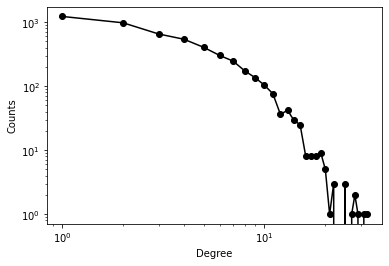

4.0072 20036


In [96]:
# top 40% highest degree vaccinated
degrees = get_geom_seq(5000,.25)
cm = nx.configuration_model(degrees)
degree_freq = nx.degree_histogram(cm)

degrees = list(range(len(degree_freq)))
plt.loglog(degrees[1:], degree_freq[1:],'ko-') 
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.show()

# Parameters of the model
beta = 0.3 #transmission rate
p = 0.1
alpha = 1

Iu0 = 0.1
Iv0 = 0.0
Su_0 = .6*(1-Iu0-Iv0)
Sv_0 = .4*(1-Iu0-Iv0)

# Initial conditions
cm_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = sum(cm_deg_sum)
avg_k = sum(cm_deg_sum) / cm.number_of_nodes()
print(avg_k, total_degree)
Suk = np.zeros((len(degree_freq))) #array for expected S_k
Svk = np.zeros((len(degree_freq))) #array for expected S_k
Iuk = np.zeros((len(degree_freq))) #array for expected I_k
Ivk = np.zeros((len(degree_freq))) #array for expected I_k

for k in range(int(len(degree_freq)*0.6)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Svk[k] = degree_freq[k]*(Sv_0)
  Ivk[k] = degree_freq[k]*(Iv0)
  Suk[k] = degree_freq[k]*(Su_0)
  Iuk[k] = degree_freq[k]*(Iu0)


for k in range(int(len(degree_freq)*0.6), len(degree_freq)):
  #set an expectation of I0 fraction of nodes of degree k infectious
  Svk[k] = degree_freq[k]*(Sv_0)
  Ivk[k] = degree_freq[k]*(Iv0)
  Suk[k] = degree_freq[k]*(Su_0)
  Iuk[k] = degree_freq[k]*(Iu0)


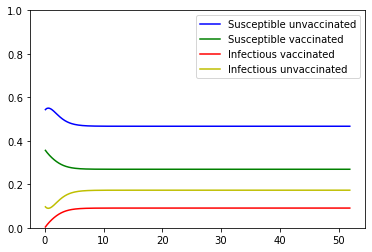

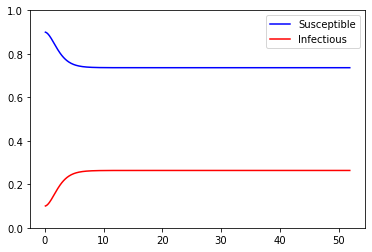

In [97]:
# Run the model

# Discrete steps of Euler's methods
res = [] #list of results
history = []
# S = S0; I = I0; #set initial conditions
h = 0.1; #timestep
T = np.arange(1,52/h)
for t in T:
  
  # Calculate the mean-field
  theta = 0.0
  for k in range(len(degree_freq)):
    theta += (k*Iuk[k] + k*Ivk[k]*(1-p))/total_degree
  history.append(theta)

  # Set initial global quantities
  Sv = 0.0
  Iv = 0.0
  Iu = 0.0
  Su = 0.0
  # Run Euler's method for all degree classes k
  for k in range(len(degree_freq)):
    # calculate speeds
    recovered_v = alpha*Ivk[k]
    recovered_u = alpha*Iuk[k]
    Svk_Ivk = (1-p)*(beta*k*theta*Svk[k])
    Suk_Iuk = (beta*k*theta*Suk[k])

    delta_Svk = recovered_v - Svk_Ivk 
    delta_Ivk = Svk_Ivk - recovered_v
    delta_Suk = recovered_u - Suk_Iuk # newly recovered - newly infected
    delta_Iuk = Suk_Iuk - recovered_u # newly infected - newly recovered

    # update dynamical variables
    Suk[k] += delta_Suk*h #Ik(t+h)
    Svk[k] += delta_Svk*h #Ik(t+h)
    Iuk[k] += delta_Iuk*h #Ik(t+h)
    Ivk[k] += delta_Ivk*h #Ik(t+h)


    # update global quantities
    Su += Suk[k]
    Sv += Svk[k]
    Iu += Iuk[k] 
    Iv += Ivk[k]
  res.append((Su/cm.number_of_nodes(),Sv/cm.number_of_nodes(), Iu/cm.number_of_nodes(), Iv/cm.number_of_nodes()))

#zip unpacked list of tuples (n-th elements all together)
#map them to arrays
Sut,Svt,Iut,Ivt = map(np.array, zip(*res))

fig,ax = plt.subplots()
ax.plot(h*T, (Sut), 'b', label='Susceptible unvaccinated')
ax.plot(h*T, Svt, "g", label="Susceptible vaccinated")
ax.plot(h*T,Ivt, 'r', label='Infectious vaccinated')
ax.plot(h*T,Iut, 'y', label='Infectious unvaccinated')
ax.set_ylim([0, 1])
ax.legend();

fig,ax = plt.subplots()
ax.plot(h*T, Svt+Sut, 'b', label='Susceptible')
ax.plot(h*T,Ivt+Iut, 'r', label='Infectious')
ax.set_ylim([0, 1])
ax.legend();

Start of Problem 4

In [28]:
# from google.colab import files
# uploaded = files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [9]:
G = nx.readwrite.graphml.read_graphml('mixed.species_brain_1.graphml')

In [ ]:
# G = nx.readwrite.graphml.read_graphml(io.BytesIO(uploaded['mixed.species_brain_1.graphml']))

In [31]:
G.nodes()

NodeView(('n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14', 'n15', 'n16', 'n17', 'n18', 'n19', 'n20', 'n21', 'n22', 'n23', 'n24', 'n25', 'n26', 'n27', 'n28', 'n29', 'n30', 'n31', 'n32', 'n33', 'n34', 'n35', 'n36', 'n37', 'n38', 'n39', 'n40', 'n41', 'n42', 'n43', 'n44', 'n45', 'n46', 'n47', 'n48', 'n49', 'n50', 'n51', 'n52', 'n53', 'n54', 'n55', 'n56', 'n57', 'n58', 'n59', 'n60', 'n61', 'n62', 'n63', 'n64'))

In [32]:
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0)

In [33]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64))

In [45]:
def set_states(G, p_firing): 
  firing = 0
  not_firing = 0
  for node in list(G.nodes()):
    die = np.random.uniform(0, 1)
    if die<p_firing:
      G.nodes[node]['state'] = 'Firing'
    else:
      G.nodes[node]['state'] = 'Not Firing'
  return G
    




In [46]:
G=set_states(G, .4)

In [47]:
def count_states(G):
  firing=0
  not_firing=0
  for node in list(G.nodes()): 
    if G.nodes[node]['state'] == 'Firing':
      firing+=1
    else:
      not_firing+=1

  return firing, not_firing



In [48]:
firing, not_firing = count_states(G)
print(firing, not_firing)

28 37


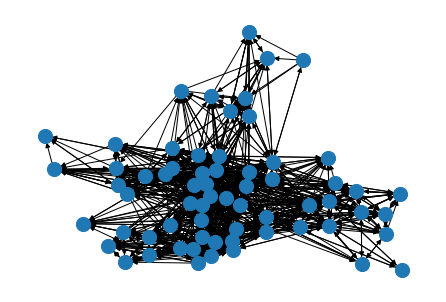

In [42]:
nx.draw(G, with_labels=False, node_size=200, pos=nx.fruchterman_reingold_layout(G))

In [43]:
def run_voter_model(T, G):
  firing_tracker = []
  not_firing_tracker = []
  for t in range(T):
    rand_node = np.random.randint(0, len(G.nodes()))
    neighbor_states = np.array([])
    for neighbor in G.neighbors(rand_node):
      neighbor_state = G.nodes[neighbor]['state']
      neighbor_states=np.append(neighbor_states,neighbor_state)
      rand_state = np.random.randint(0, len(neighbor_states))
      G.nodes[rand_node]['state'] = neighbor_states[rand_state]
    firing, not_firing = count_states(G)
    firing_tracker.append(firing)
    not_firing_tracker.append(not_firing)
  return G, firing_tracker, not_firing_tracker
  




In [56]:
# initial conditions
p_firings = [.25, .5, .75]
T = 2500

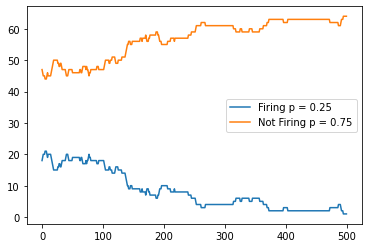

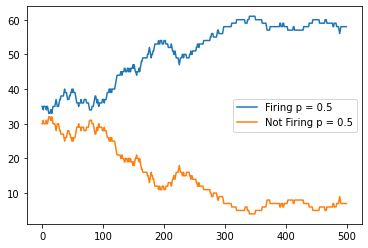

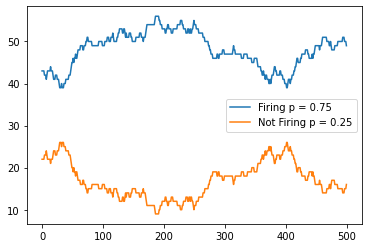

In [ ]:
for i in range(len(p_firings)):
  G = set_states(p_firings[i])
  G, firing_tracker, not_firing_tracker = run_voter_model(T, G)
  plt.figure(f'{i}')
  plt.plot(np.arange(0, T, 1), firing_tracker, label = f'Firing p = {p_firings[i]}')
  plt.plot(np.arange(0, T, 1), not_firing_tracker, label = f'Not Firing p = {1-p_firings[i]}')
  plt.legend()

In [49]:
G = set_states(cm, .4)

In [50]:
count_states(G)

(394, 606)

In [52]:
G, firing_tracker, not_firing_tracker = run_voter_model(T, G)


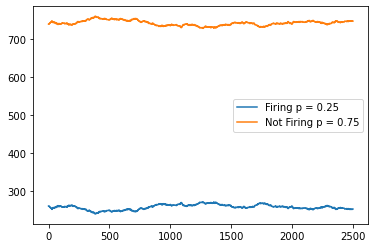

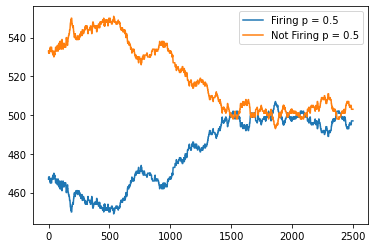

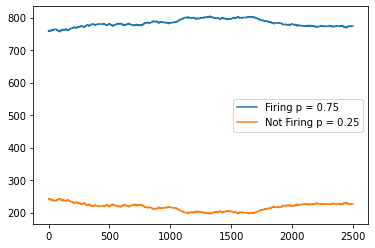

In [57]:
for i in range(len(p_firings)):
    G = set_states(cm, p_firings[i])
    G, firing_tracker, not_firing_tracker = run_voter_model(T, G)
    plt.figure(f'{i}')
    plt.plot(np.arange(0, T, 1), firing_tracker, label = f'Firing p = {p_firings[i]}')
    plt.plot(np.arange(0, T, 1), not_firing_tracker, label = f'Not Firing p = {1-p_firings[i]}')
    plt.legend()